# Analysis of bulk RNA-seq dataset of 27 NSCLC cancer patients receiving ICB

Data was obtained from [Jung et al., 2019](https://www.nature.com/articles/s41467-019-12159-9#Sec24) associated GEO [GSE135222](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE135222).

In [1]:
import pandas as pd
import scanpy as sc
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from scipy.stats import spearmanr

## 0. Read in files and format

In [2]:
# read in expression matrix
exmat = pd.read_csv("/path/to/GSE135222_raw_counts_GRCh38.p13_NCBI.tsv", sep='\t')

# set gene names as index
exmat = exmat.set_index("GeneID")
X = exmat.T

# read in metadata
meta = pd.read_csv("/path/to/lung_metadata.csv")
meta = meta.set_index("GSM")

In [3]:
# convert gene ID to gene symbol

gene_convert = pd.read_csv('/path/to/fData_IMvigor210.csv')

gene_convert = gene_convert.set_index("entrez_id")

id2sym = gene_convert["symbol"].dropna().astype(str).to_dict()

exmat_sym = exmat.rename(index=id2sym)

X = exmat_sym.T

In [4]:
# set sample IDs as index in metadata
meta.index.name = "sample_id"

# transpose X so samples are rows, genes are columns
X_t = X.T  

# ensure both datasets have the same sample order
common_samples = X_t.columns.intersection(meta.index)

X_t = X_t[common_samples]
meta_aligned = meta.loc[common_samples]

## 1. Perform DESeq to obtain size-factor normalized expression matrix

In [5]:
# initialize deseq
dds = DeseqDataSet(
    counts=X,
    metadata=meta_aligned,
    design_factors="Response"
)

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
# run deseq
dds.deseq2()

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 3.39 seconds.

Fitting dispersion trend curve...
... done in 0.59 seconds.

Fitting MAP dispersions...
... done in 4.01 seconds.

Fitting LFCs...
... done in 2.63 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 5376 outlier genes.

Fitting dispersions...
... done in 0.55 seconds.

Fitting MAP dispersions...
... done in 0.51 seconds.

Fitting LFCs...
... done in 0.43 seconds.



In [7]:
# extract normalized expression matrix

dds_obs_df = pd.DataFrame(dds.obs)
dds_var_df = pd.DataFrame(dds.var)
dds_matrix_df = pd.DataFrame(dds.layers['normed_counts'], index=dds.obs.index, columns=dds.var.index)

norm_counts_pre = pd.concat([dds_obs_df, dds_matrix_df], axis=1)

## 2. Convert to AnnData object

In [8]:
adata = sc.AnnData(norm_counts_pre.iloc[:,16:])
adata.obs = meta_aligned

In [9]:
adata

AnnData object with n_obs × n_vars = 27 × 39376
    obs: 'Patient_n', 'Age', 'Gender', 'Therapy', 'PFS', 'PFS_FLAG', 'Response', 'TME Subtype', 'Mutation_Load', 'TMB', 'Global_Methylation_Level', 'library_strategy', 'platform_id', 'SAMN', 'SRA', 'series_id'

## 3. Plot survival curves for ELF3 expression

In [10]:
# define gene signatures
ICB_res = [
    "PRSS27", "ELF3", "DESI1", "LTF", "PGLYRP4", "PDZK1IP1", "SPNS2", "PSCA", "PRSS22", "TMPRSS11G",
    "GSTO1", "KRT19", "MUC20", "TSPAN1", "DUOXA2", "TMEM242", "TMC5", "ECM1", "CBLC", "CCDC129", 
    "PRSS27P", "CAPN5", "GLRX", "SPNS3", "TMPRSS11E", "ZSCAN32", "TP53INP2", "SLC6A14", "DYNAP", 
    "DUSP4", "CLDN23", "CCDC69", "CLIC5", "GRPEL2", "APOL7B", "GDE1", "MAL", "DUOX2", "NUPR1", 
    "CLDN1", "P2RY2", "IRF7", "S100A14", "CDKN2B", "MALL", "PLEKHS1", "AC168977.1", "MUC4", "FXYD4", 
    "LY6G6D", "TRIM15", "MAL2", "WNT7B", "IFT22", "PLET1", "PPBP", "HIST1H1C", "CRYBA4", "KRT7", "HSD17B7", 
    "CLCA1", "TMPRSS11F", "SERPINB9", "CCDC186", "MYZAP", "SLC9A3R1", "PTTG1IP", "SLC28A3", "CIDEA", 
    "TMEM190", "PCDH11Y", "ARG1", "4930459C07RIK", "BSPRY", "CCDC12", "PIGR", "KRT23", "1810044K17RIK", 
    "CYP2D6", "PBP2", "CXCL5", "TMPRSS4", "LPCAT4", "CCDC71L", "ARHGAP27OS1", "EPS8L2", "TMPRSS11B", 
    "SERPINB9", "CSF3", "IFIT1", "LIPH", "EPHB3", "AA986860", "LGALS3", "RASSF7", "GRHL1", 
    "GFPT1", "TRIM16", "SPRR2D"
]

ICB_resp = [
    "GBP6", "GBP2", "IIGP1", "CNTN1", "TMEM226", "OR56A4", "MILL1", "CXCL10", "GBP4", "IFIT3", 
    "APOL10", "IFI47", "GBP5", "SLCO2A1", "PRL", "GREB1L", "GBP8", "CCL7", "TMEM121", "ZBED2", 
    "APOL9", "GPR176", "ADGRB3", "PRL", "CCL2", "RGS4", "IFIT1", "SERPINA3", "IRF1", "ASIC2", 
    "CXCL9", "MS4A4A", "IFIH1", "ZBTB8B", "ALOX12", "NRG1", "GHR", "GRIN2D", "CLIC4", "ROBO2", 
    "CCDC166", "LAMA3", "FAM126A", "ERLIN2", "GNB4", "AMMECR1", "ZC3H12C", "PRL", "SAMD5", 
    "FCGBP", "PLCB1", "FLNB", "CYP7B1", "IL24", "ALOX15", "IFIT3", "NCAM1", "CSPR2", "CD44", 
    "IL18R1", "SERPINB2", "EFEMP1", "TENM1", "CCL8", "SLC6A4", "HAS2", "UBD", "NPPB", "CCL11", 
    "FAP", "PCDH7", "IGFN1", "IFI16", "TNC", "MAJIN", "CSMD1", "ROBO1", "VCAM1", "IRF7", 
    "ZC3H12A", "NPAS3", "ITGB6", "DCLK1", "NEK10", "LY75", "CFAP47", "SLC4A7", "VEGFC", 
    "CNGA1", "HCN1", "SYT1", "SLCO1A2", "GDNF", "TENM3", "ERC1", "SKINT3", "PDLIM1", 
    "DNAH8", "CSNK1G3", "TNIP3"
]

In [11]:
# score tumors for gene sets
sc.tl.score_genes(adata, ICB_res, score_name='ICB_res')
sc.tl.score_genes(adata, ICB_resp, score_name='ICB_resp')
sc.tl.score_genes(adata, ['ELF3'], score_name='elf3')

       '1810044K17RIK', 'PBP2', 'ARHGAP27OS1', 'AA986860'],
      dtype='object')
       'ADGRB3', 'CSPR2', 'MAJIN', 'CFAP47', 'SKINT3'],
      dtype='object')


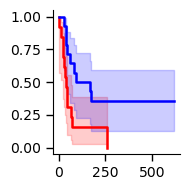

In [12]:
# Plot KM curve for ELF3 expression
score = "elf3"
N = 14

# ── Step 1: Create dataframe with required info ───────────────
df = adata.obs[[score, "PFS", "PFS_FLAG"]].dropna().copy()

# 'PFS' = survival time
# 'PFS_event' = 1 if event occurred, 0 if censored (you may need to create this)

# ── Step 2: Rank by score and assign groups ─────────────────
df["res_group"] = "Other"
df.loc[df[score].nlargest(N).index, "res_group"] = "High"
df.loc[df[score].nsmallest(N).index, "res_group"] = "Low"
df = df[df["res_group"].isin(["High", "Low"])]  # keep only top/bottom N

# ── Step 3: Fit KM curves ─────────────────────────────────────
kmf = KaplanMeierFitter()

plt.figure(figsize=(2, 2))
for group, color in zip(["High", "Low"], ["red", "blue"]):
    ix = df["res_group"] == group
    kmf.fit(durations=df.loc[ix, "PFS"],
            event_observed=df.loc[ix, "PFS_FLAG"],
            label=f"{group} score")
    ax = kmf.plot(ci_show=True, color=color, linewidth=1.8, ci_alpha=0.2)

# ── Style plot ────────────────────────────────────────────────
ax.set_xlabel("Progression-Free Survival (days)", color='black')
ax.set_ylabel("Survival probability", color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', direction='out', length=5, width=1, colors='black')
ax.legend(frameon=False).remove()
plt.xlabel("")
plt.ylabel("")

plt.tight_layout()
#plt.savefig("KM_ELF3_PFS.png", dpi=600)
plt.show()

In [13]:
# calculate significance by log-rank test

# Subset to top and bottom N
score = "elf3"
N = 14
df = adata.obs[[score, "PFS", "PFS_FLAG"]].dropna().copy()

# Label groups
df["group"] = "Other"
df.loc[df[score].nlargest(N).index, "group"] = "High"
df.loc[df[score].nsmallest(N).index, "group"] = "Low"
df = df[df["group"].isin(["High", "Low"])]

# Split into two groups
group_high = df[df["group"] == "High"]
group_low = df[df["group"] == "Low"]

# Perform log-rank test
results = logrank_test(
    group_high["PFS"], group_low["PFS"],
    event_observed_A=group_high["PFS_FLAG"],
    event_observed_B=group_low["PFS_FLAG"]
)

# Output result
print(f"Log-rank p-value: {results.p_value:.4f}")
results.print_summary()


Log-rank p-value: 0.0143


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.00 0.01      6.13

## 4. Correlate ELF3 expression with TME features

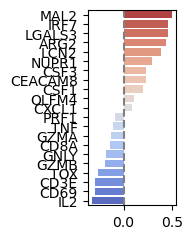

In [17]:
# define geneset to test (mix of ICB-resistance genes, neutrophil markers, T cell markers,
# and T cell cytotoxicity genes
geneset = ["MAL2","IRF7","NUPR1","LGALS3","CSF3","CXCL1","CSF1","CSF3",
                "ARG2","CEACAM8","LCN2","OLFM4",
                 "CD8A","CD3","TOX","GZMA","GZMB","GNLY","CD69","PRF1","TNF","IL2","CD3E"
                ]

# make sure genes are in dataset
valid_genes = [g for g in geneset if g in adata.var_names]

# initialize list to store correlation results
results = []
# loop through genes and compute ELF3 correlation
for gene in valid_genes:
    x = adata.obs["elf3"]
    y = adata[:, gene].X.toarray().flatten() if hasattr(adata[:, gene].X, "toarray") else adata[:, gene].X.flatten()
    
    # remove any NAs
    mask = (~pd.isna(x)) & (~pd.isna(y))
    # compute correlation if >2 data points
    if mask.sum() > 2:
        rho, pval = spearmanr(x[mask], y[mask])
        results.append({
            "gene": gene,
            "rho": rho,
            "pval": pval
        })

# convert results to a dataframe and sort by descending correlation with ELF3
corr_df = pd.DataFrame(results).sort_values("rho", ascending=False)

# format plot

plt.figure(figsize=(2, 2.5))
sns.barplot(data=corr_df, y="gene", x="rho", palette="coolwarm_r")
plt.axvline(0, color="gray", linestyle="--")
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
#plt.savefig('ELF3_corr_genes.png', dpi=600)
plt.show()


## 5. Plot ICB-resistance or IFN-response programs based on ELF3-high or -low status

0.02116699156773605


/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


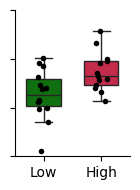

In [18]:

# separate box plot by ELF3-high or -low score
score = "elf3"
# 14 samples per group (split in half)
N = 14
# plot ICB-resistance score on y-axis
geneset = ICB_res
# set colors
custom = {"High":"crimson","Low":"green"}

# create dataframe and assign ELF3 expression category
df = adata.obs[[score, "PFS", "PFS_FLAG"]].dropna().copy()
df["res_group"] = "Other"
df.loc[df[score].nlargest(N).index, "res_group"] = "High"
df.loc[df[score].nsmallest(N).index, "res_group"] = "Low"
df = df[df["res_group"].isin(["High", "Low"])]  # keep only top/bottom

# subset AnnData (new object)
adata_subset = adata[df.index]

# apply score
valid_genes = [g for g in geneset if g in adata.var_names]
sc.tl.score_genes(adata_subset, gene_list=valid_genes, score_name="geneset_score")

# export scores from adata to the dataframe
df["geneset_score"] = adata_subset.obs["geneset_score"]

# MWU test to compare scores
group_high = df[df["res_group"] == "High"]["geneset_score"]
group_low = df[df["res_group"] == "Low"]["geneset_score"]
stat, pval = mannwhitneyu(group_high, group_low, alternative='two-sided')

print(pval)

# format and show plot
plt.figure(figsize=(1.5, 2))
ax = sns.boxplot(data=df, x="res_group", y="geneset_score", palette=custom, fliersize=0, width=0.6)
sns.stripplot(data=df, x="res_group", y="geneset_score", color="black", size=4, jitter=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(plt.yticks()[0], [''] * len(plt.yticks()[0]))
plt.ylim(-2000,4000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
#plt.savefig('ELF3_corr_ifnresp.png', dpi = 600)
plt.show()


0.08494665681641869


/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


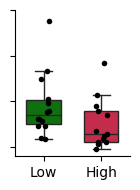

In [21]:
# separate box plot by ELF3-high or -low score
score = "elf3"
# 14 samples per group (split in half)
N = 14
# plot IFN-response score on y-axis
geneset = ICB_resp
# set colors
custom = {"High":"crimson","Low":"green"}

# create dataframe and assign ELF3 expression category
df = adata.obs[[score, "PFS", "PFS_FLAG"]].dropna().copy()
df["res_group"] = "Other"
df.loc[df[score].nlargest(N).index, "res_group"] = "High"
df.loc[df[score].nsmallest(N).index, "res_group"] = "Low"
df = df[df["res_group"].isin(["High", "Low"])]  # keep only top/bottom

# subset AnnData (new object)
adata_subset = adata[df.index]

# apply score
valid_genes = [g for g in geneset if g in adata.var_names]
sc.tl.score_genes(adata_subset, gene_list=valid_genes, score_name="geneset_score")

# export scores from adata to the dataframe
df["geneset_score"] = adata_subset.obs["geneset_score"]

# MWU test to compare scores
group_high = df[df["res_group"] == "High"]["geneset_score"]
group_low = df[df["res_group"] == "Low"]["geneset_score"]
stat, pval = mannwhitneyu(group_high, group_low, alternative='two-sided')

print(pval)

# format and show plot
plt.figure(figsize=(1.5, 2))
ax = sns.boxplot(data=df, x="res_group", y="geneset_score", palette=custom, fliersize=0, width=0.6)
sns.stripplot(data=df, x="res_group", y="geneset_score", color="black", size=4, jitter=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(plt.yticks()[0], [''] * len(plt.yticks()[0]))
plt.ylim(-200,3000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
#plt.savefig('ELF3_corr_ifnresp.png', dpi = 600)
plt.show()
